# Weekly LAI: exploratory analysis and processing

In [157]:
import os
import time
import datetime
import random as rd
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

Change the filepath to the path containing the netcdf file:

In [158]:
filepath = '/home/stijndc/Desktop/datafiles/SAT_EX/netcdf files/' 

Read in the file, apply the scaling factor and extract the LAI, latitude, longitude and timestamps:

In [159]:
LAI_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI.AVHRR.V004.1982-2015_1.nc'),
                     'r', format='NETCDF3')

LAI_netcdf.set_auto_maskandscale(False)

LAI = LAI_netcdf.variables['LAI'][::]*float(LAI_netcdf.variables['LAI'].scale_factor)
LAI = LAI[:,::-1,:]

lat = LAI_netcdf.variables['lat'][::-1]
lon = LAI_netcdf.variables['lon'][:]
timestamps = LAI_netcdf.variables['time'][:]

In [160]:
LAI_netcdf

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions: CF-1.4
    history: Tue Feb 21 11:11:34 2017: cdo -P 4 remapbil,/media/Matthias_2/data/cmip5/griddata/1_GHCN_grid GLASSLAI.AVHRR.V004.1982-2015.nc GLASSLAI.AVHRR.V004.1982-2015_1.nc
Mon Feb 20 14:09:12 2017: cdo -P 4 setdate,1982-01-01 -settaxis,1982-01-01,00:00:00 -settunits,days GLASSLAI.AVHRR.1982001.V004.nc /media/Matthias_2/data/cmip5/OBS/Vegetation/GLASSLAI2/tmp/tmp1.nc
    cdo_openmp_thread_number: 4
    CDO: Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/cdo)
    dimensions(sizes): lon(360), lat(180), time(1564)
    variables(dimensions): float64 lon(lon), float64 lat(lat), float64 time(time), int16 LAI(time,lat,lon)
    groups: 

Let's look at a couple of randomly sampled pixels:

In [182]:
def show_timeseries(ndarr, ts, color='#1b7837', reproduce=True):
    """
    Randomly sample 15 pixels, plot LAI time series. 
    If a pixel with missing data is sampled, resample. 
    
    Arguments:
    ndarr: 3d ndarray from netcdf file
    ts: unix timestamps
    reproduce: fix seed if True
    """
    
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
    if reproduce:
        rd.seed(42) # set seed to sample the same pixels everytime
    for axrow in axes:
        for ax in axrow:

            # choose random pixel, resample if it's a sea pixel
            i, j = rd.randint(0, ndarr.shape[1]-1), rd.randint(0, ndarr.shape[2]-1)
           
            while(len(np.unique(ndarr[:,i,j])) == 1):
                i, j = rd.randint(0, ndarr.shape[1]-1), rd.randint(0, ndarr.shape[2]-1)
            # plot image
            temp = pd.Series(ndarr[:, i,j], index=pd.to_datetime(ts+4383, unit='d'))
            temp.plot(ax=ax, kind='line', color=color, 
                     sharex=True, sharey=True)
            print(i, j)
            # add title
            ax.set_title('Lat {}, Lon {}'.format(lat[i],lon[j]))

(49, 80)
(116, 196)
(39, 212)
(68, 198)
(41, 104)
(18, 100)
(114, 131)
(66, 75)
(30, 262)
(56, 96)
(47, 88)
(105, 323)
(71, 78)
(53, 230)
(85, 197)


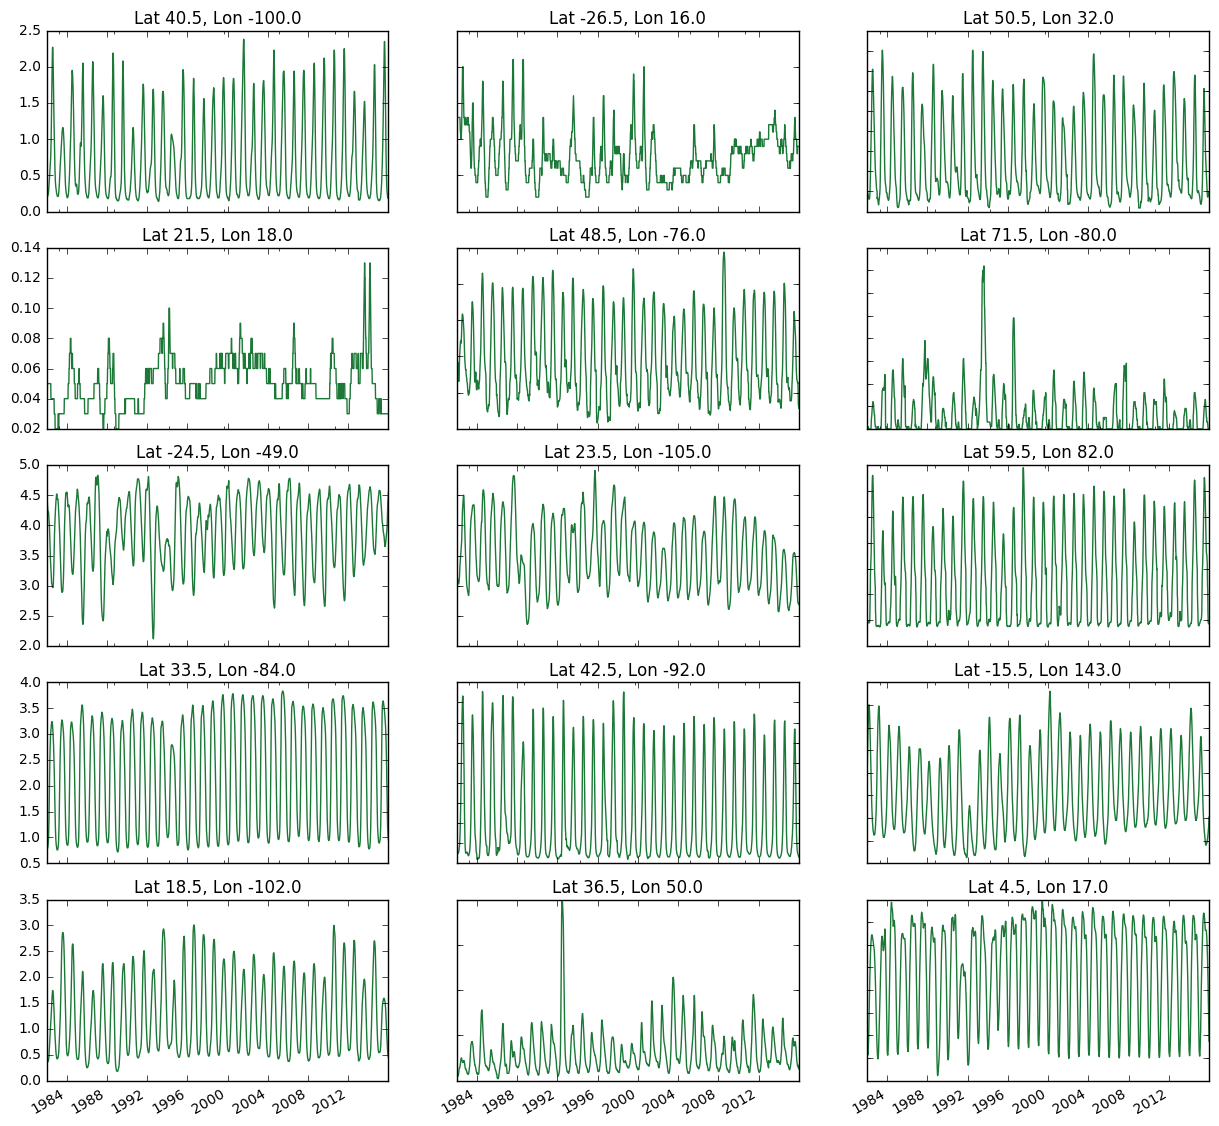

In [183]:
show_timeseries(LAI, ts=timestamps)

# 1. Detrend the time series

The LAI time series are certainly not stationary all around the globe. Let's remove the trend using [cdo](https://code.zmaw.de/projects/cdo/embedded/index.html#x1-5310002.10.2):

`cdo trend infile afile bfile
cdo subtrend infile afile bfile outfile`

First, let's have a look at some detrended timeseries:

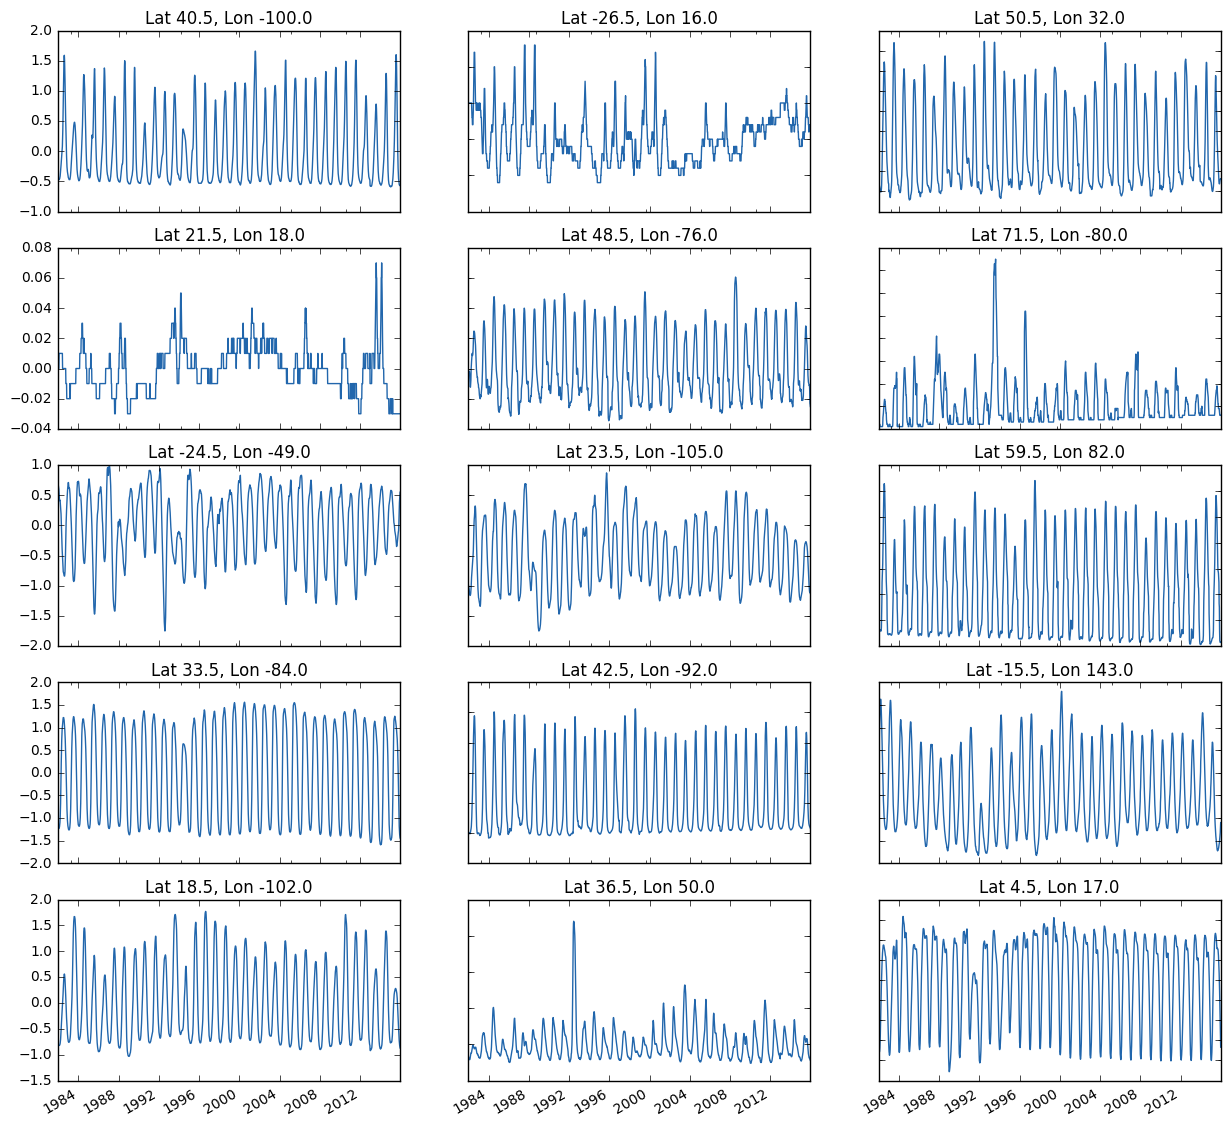

In [141]:
LAI_detrend_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI_DETREND.nc'),
                     'r', format='NETCDF3')
LAI_detrend_netcdf.set_auto_maskandscale(False)

LAI_detrend = LAI_detrend_netcdf['LAI'][::]*float(LAI_detrend_netcdf.variables['LAI'].scale_factor)
LAI_detrend = LAI_detrend[:,::-1,:]
timestamps = LAI_detrend_netcdf.variables['time'][:]

show_timeseries(LAI_detrend, color='#2166ac', ts=timestamps)

The main effect of detrending is that the signals are now centered around zero:

In [142]:
np.mean(LAI_detrend, axis=0)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [143]:
np.var(np.mean(LAI_detrend, axis=0))

5.855919845476003e-08

# 2. Remove periodic component

Compute the multi-year daily mean with `cdo`:
    
`cdo ydaymean infile outfile`


(49, 80)
(116, 196)
(39, 212)
(68, 198)
(41, 104)
(18, 100)
(114, 131)
(66, 75)
(30, 262)
(56, 96)
(47, 88)
(105, 323)
(71, 78)
(53, 230)
(85, 197)


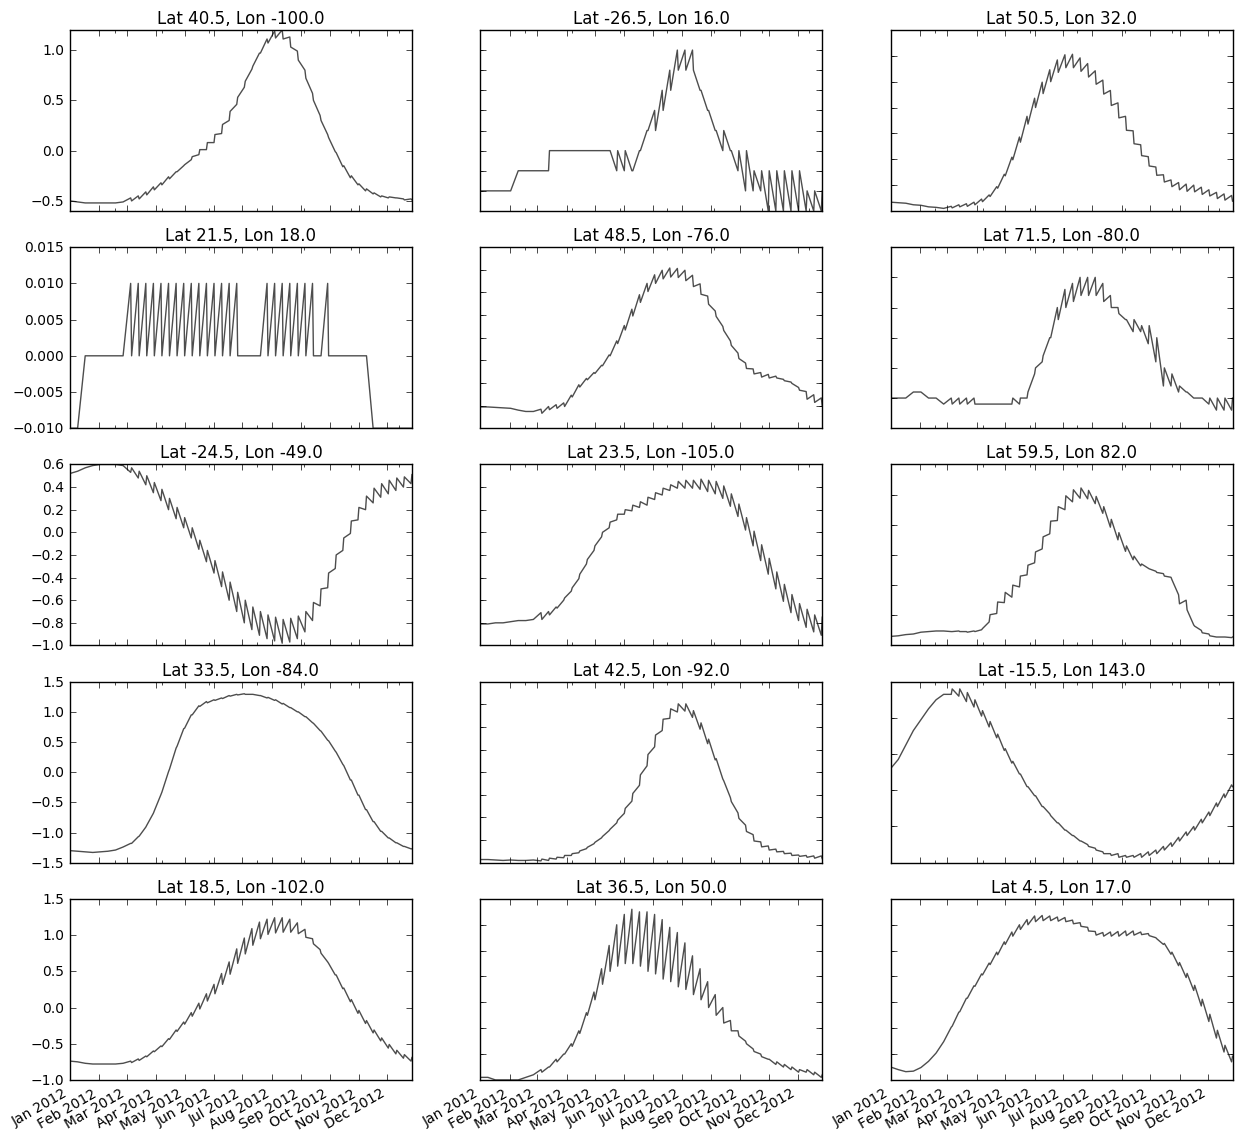

In [184]:
LAI_ydaymean_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI_ydaymean.nc'),
                     'r', format='NETCDF3')
LAI_ydaymean_netcdf.set_auto_maskandscale(False)

LAI_ydaymean = LAI_ydaymean_netcdf['LAI'][::]*float(LAI_ydaymean_netcdf.variables['LAI'].scale_factor)
LAI_ydaymean = LAI_ydaymean[:,::-1,:]
timestamps_ydaymean = LAI_ydaymean_netcdf.variables['time'][:]
show_timeseries(LAI_ydaymean, color='#4d4d4d', ts=timestamps_ydaymean, reproduce=True)

### **There is still a problem here. The ydaymean is calculated for 86 different days, probably because of leap years. As a consequence, the multi-year mean is not smooth at all in some pixels? Needs to be addressed**

In [154]:
len(np.unique(pd.to_datetime(timestamps, unit='d').dayofyear))

46

In [155]:
len(np.unique(pd.to_datetime(timestamps_ydaymean, unit='d').dayofyear))

84

# 3. Calculate residuals

Finally, subtract the multi-year daily average from the detrended time series to obtain the residuals:
    
`cdo sub infile ydaymeanfile outfile`

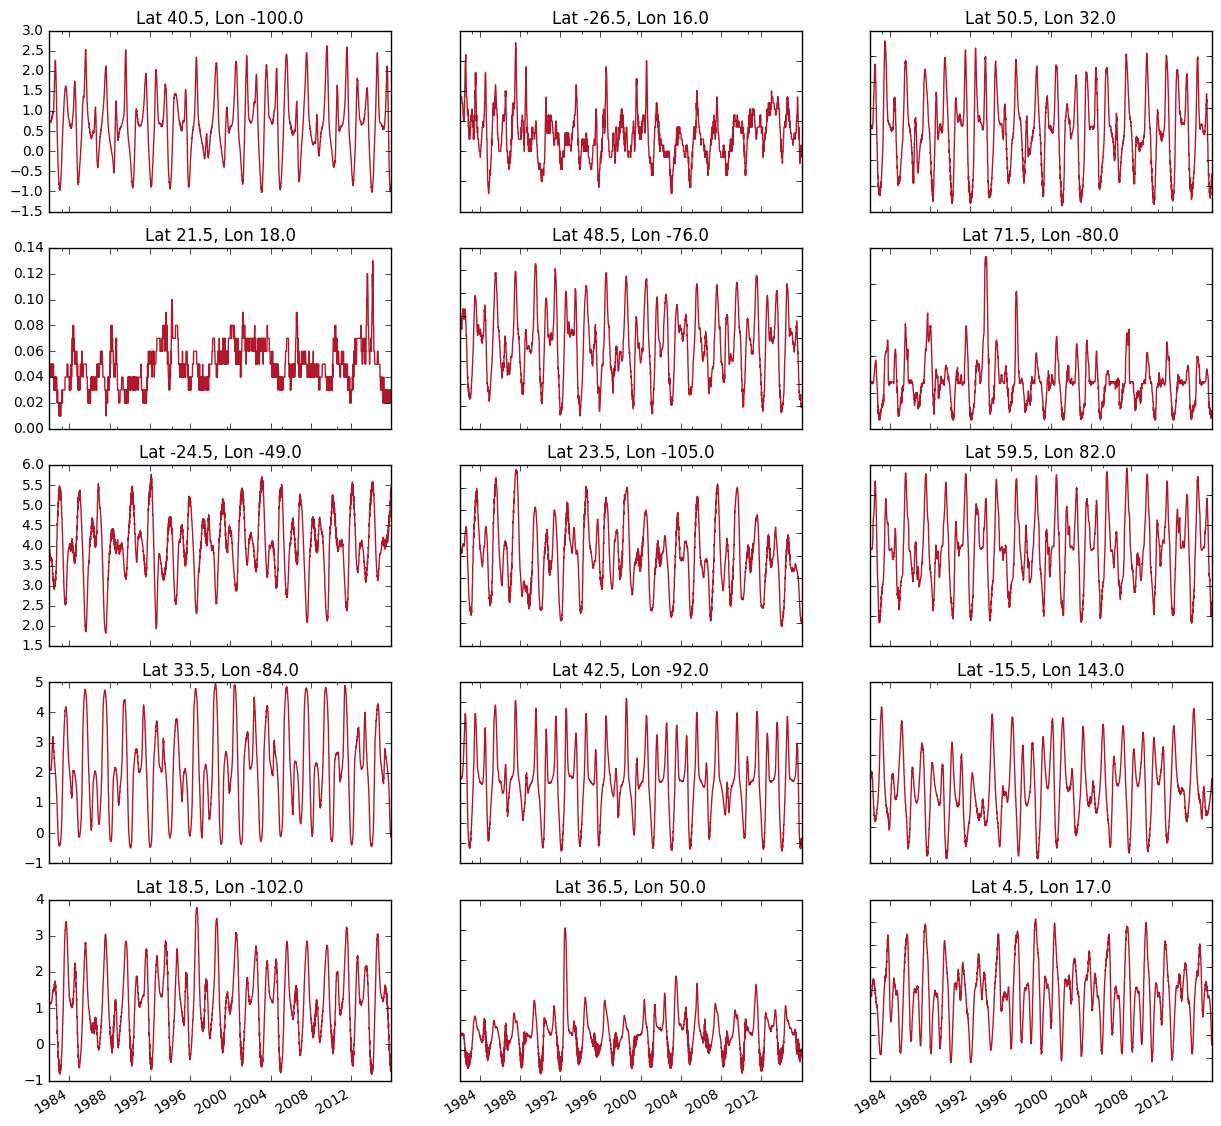

In [156]:
LAI_residuals_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI_residuals.nc'),
                     'r', format='NETCDF3')
LAI_residuals_netcdf.set_auto_maskandscale(False)

LAI_residuals = LAI_residuals_netcdf['LAI'][::]*float(LAI_residuals_netcdf.variables['LAI'].scale_factor)
LAI_residuals = LAI_residuals[:,::-1,:]
timestamps = LAI_residuals_netcdf.variables['time'][:]
show_timeseries(LAI_residuals, color='#b2182b', ts=timestamps)

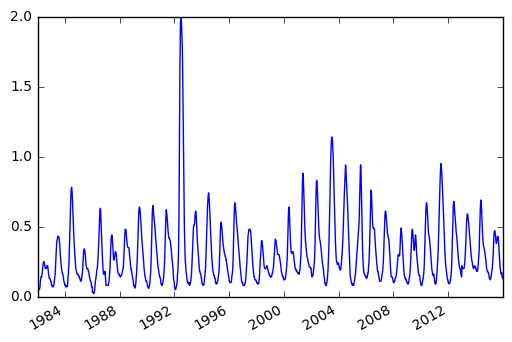

In [187]:
pixel = pd.Series(LAI[:, 53, 230], index=pd.to_datetime(timestamps+4383, unit='d'))
pixel.plot()

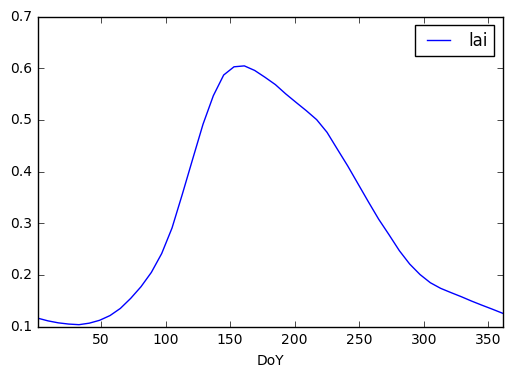

In [188]:
df = pd.DataFrame(pixel, columns=['lai'])
df['DoY'] = df.index.dayofyear
df.groupby(['DoY']).mean().plot()

In [189]:
pixel_resid = (df - df.groupby(['DoY']).transform('mean'))['lai']


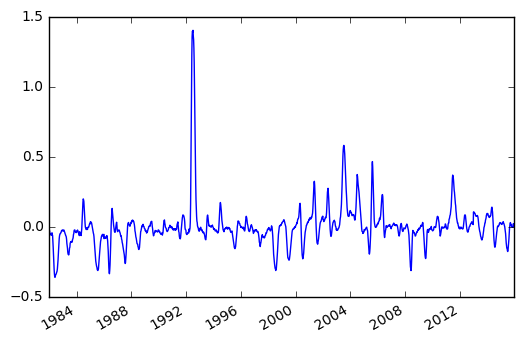

In [190]:
pixel_resid.plot()


# Second attempt: use xarray